# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

!rm -rf logs/B2R2_VANILLA/ model/B2R2_VANILLA

In [1]:
TRAIN_NAME='B2R2_VANILLA'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.125 # gpu capacity in percentage

In [2]:
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

# Data Processing Module
from DataModule import one_hot_encoder, VISION_dX, VISION_dY
from Utils import MovingAverage as MA
from Utils import Experience_buffer, discount_rewards

## Hyperparameters

In [3]:
# Training Related
total_episodes = 500000 #Set total number of episodes to train agent on.
max_ep = 150
update_frequency = 50
batch_size = 2000
experience_size=50000

# Saving Related
save_network_frequency = 1000
save_stat_frequency = 100
moving_average_step = 100

# Parameters
LEARNING_RATE = 1e-4
gamma = 0.99
MAP_SIZE = 10

## Environment Setting

In [4]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

red number :  2
blue number :  2


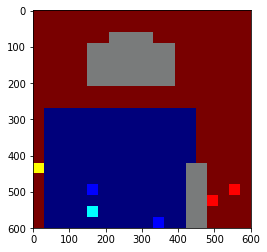

In [ ]:
env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)
plt.imshow(env.render(mode='rgb_array'))
# Environment Related
action_space = 5
n_agent = len(env.get_team_blue)

print('red number : ', len(env.get_team_red))
print('blue number : ', len(env.get_team_blue))

## Network Setting

In [ ]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        
        layer = slim.conv2d(self.state_input, 16, [5,5], activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv1')
        #layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 16, [3,3], activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv2')
        layer = slim.flatten(layer)
        #flat  = tf.reshape(conv, [-1, VISION_dX*VISION_dY*128])
        #layer = slim.dropout(layer,keep_prob=0.8)
        #layer = slim.fully_connected(layer, 516,
        #                            activation_fn=tf.nn.relu,
        #                            biases_initializer=None,
        #                            scope='hidden_fc1')
        layer = layers.fully_connected(layer, 128, 
                                    activation_fn=tf.nn.relu)
        layer = layers.fully_connected(layer, 128, 
                                    activation_fn=tf.nn.relu)
        self.dense = layers.fully_connected(layer, action_size,
                                    activation_fn=None,
                                    scope='output_fc')
        self.output = tf.nn.softmax(self.dense, name='action')
        
        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
    
        with tf.name_scope('action_placement'):
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
            self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder

        with tf.name_scope('Loss'):
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes) # output
            self.loss = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.reward_holder)

        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)

        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            
        '''with tf.name_scope('Loss'):            
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=self.dense, labels=self.action_holder)*self.reward_holder)
        
        with tf.name_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.update_batch = optimizer.minimize(self.loss)'''
            
        with tf.name_scope('gradients'):
            self.gradients = tf.gradients(self.loss,tvars)
            self.gradients = [tf.clip_by_norm(grad, 50) for grad in self.gradients]
            #self.gradients = optimizer.compute_gradients(self.loss, tvars)
            

        with tf.name_scope('update'):
            self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))
                            
        # Summary
        # Histogram output
        with tf.variable_scope('debug_parameters'):
            tf.summary.histogram('output', self.output)
            tf.summary.histogram('actor', self.dense)     
            tf.summary.histogram('action', self.action_holder)
        
        # Graph summary Loss
        with tf.variable_scope('summary'):
            tf.summary.scalar(name='total_loss', tensor=self.loss)
        
        with tf.variable_scope('weights_bias'):
            # Histogram weights and bias
            for var in slim.get_model_variables():
                tf.summary.histogram(var.op.name, var)
                
        with tf.variable_scope('gradients'):
            # Histogram Gradients
            for var, grad in zip(slim.get_model_variables(), self.gradients):
                tf.summary.histogram(var.op.name+'/grad', grad[0])

In [ ]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=LEARNING_RATE,in_size=[None,VISION_dX,VISION_dY,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

/home/namsong/github/ctf_public/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Session

In [ ]:
# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY, allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session()

ma_reward = MA(moving_average_step)
ma_length = MA(moving_average_step)
ma_captured = MA(moving_average_step)

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

INFO:tensorflow:Restoring parameters from ./model/B2R2_VANILLA/ctf_policy.ckpt-3000
Load Model :  ./model/B2R2_VANILLA/ctf_policy.ckpt-3000


In [ ]:
def record(summary_):
    with tf.device('/cpu:0'): 
        summary = tf.Summary()
        summary.value.add(tag='Records/mean_reward', simple_value=ma_reward())
        summary.value.add(tag='Records/mean_length', simple_value=ma_length())
        summary.value.add(tag='Records/mean_succeed', simple_value=ma_captured())
        writer.add_summary(summary, sess.run(global_step))
        
        #summary_str = sess.run(merged,feed_dict={myAgent.state_input:obs})
        writer.add_summary(summary_, sess.run(global_step))
        
        writer.flush()

In [ ]:
gradBuffer = sess.run(tf.trainable_variables())
def clear_buffer():
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0 #np.zeros(grad.shape)

In [ ]:
def policy_rollout(DETERMINISTIC=True):
    # Run single episode, return the results
    s = env.reset(map_size=MAP_SIZE, policy_red=policy_red)
    #obs = one_hot_encoder(s, env.get_team_blue) # partial observation
    obs_next = one_hot_encoder(env._env, env.get_team_blue)
    
    ep_history = []
    indv_history = [[] for _ in range(len(env.get_team_blue))]
    
    was_alive = [ag.isAlive for ag in env.get_team_blue]
    prev_reward=0
    frame=0
    for frame in range(max_ep+1):
        obs = obs_next
        
        with tf.device('/cpu:0'):
            #Probabilistically pick an action given our network outputs.
            act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
        if DETERMINISTIC:
            act = np.argmax(act_prob, axis=1).tolist()
        else:
            act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)] # divide by sum : normalize
            
        s,r1,d,_ = env.step(act) #Get our reward for taking an action given a bandit.

        r = r1-prev_reward

        if frame == max_ep and d == False:
            #r -= frame * (30/1000)
            r = -100
            r1 = -100

        obs_next = one_hot_encoder(env._env, env.get_team_blue) # Full Observation
        
        # Push history for individual that 'was' alive previous frame
        for idx, agent in enumerate(env.get_team_blue):
            if was_alive[idx]:
                indv_history[idx].append([obs[idx],act[idx],r])

        # If reward sequence change, push the history into the episode history.
        '''if prev_reward != r:
            for idx, history in enumerate(indv_history):
                if len(history)==0: continue
                if not was_alive[idx]: continue
                _history = np.array(history)
                _history[:,2] = discount_rewards(_history[:,2])
                ep_history.extend(_history)'''
        
        # State Transition
        prev_reward = r1
        was_alive = [ag.isAlive for ag in env.get_team_blue]
        
        if d:
            break

    for idx, history in enumerate(indv_history):
        if len(history)==0: continue
        _history = np.array(history)
        _history[:,2] = discount_rewards(_history[:,2], gamma)
        ep_history.extend(_history)
            
    if len(ep_history) > 0:        
        ep_history = np.stack(ep_history)
    
    return [frame, ep_history, r1, env.blue_win, obs]

## Training

In [ ]:
if __name__=='__main__':
    ep = sess.run(global_step)

    exp_buffer = Experience_buffer(experience_shape=3)
    clear_buffer()
    lost_pass = 1
    try:
        progbar = tf.keras.utils.Progbar(total_episodes,width=5)
        while ep < total_episodes+1:
            # Run episode
            frame, history, reward, did_won, obs = policy_rollout(DETERMINISTIC=False)

            # Add history
            #if did_won or np.random.random_sample() < lost_pass:
            exp_buffer.add(history)

            batch_history = exp_buffer.sample(batch_size) # Sample from experience replay
            if len(batch_history) > 0:
                feed_dict={myAgent.reward_holder:batch_history[:,2],
                       myAgent.action_holder:batch_history[:,1],
                       myAgent.state_input:np.stack(batch_history[:,0])}
                with tf.device('/gpu:0'):
                    loss, grads, summary_ = sess.run([myAgent.loss, myAgent.gradients, merged], feed_dict=feed_dict)
                if ep % save_stat_frequency == 0 and ep != 0:
                    record(summary_)

                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

            if ep % update_frequency == 0 and ep != 0:
                feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                with tf.device('/gpu:0'):
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                clear_buffer()
                exp_buffer.flush()
                
            ma_reward.append(reward)
            ma_length.append(frame)
            ma_captured.append(env.blue_win)
            
            # save every 100 ep
            if ep % save_network_frequency == 0 and ep != 0:
                #print(' Average r : ', np.mean(ma_reward[-save_network_frequency:]))
                saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
                #print("save weights: ", sess.run(global_step), 'episodes')

            ep += 1
            progbar.update(ep) # update progress bar
            sess.run(increment_global_step_op)

    except KeyboardInterrupt:
        print('\n\nManually stopped the training (KeyboardInterrupt)');
        saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
        print("save: ", sess.run(global_step), 'episodes')

 77443/500000 [.....] - ETA: 8:07:59